In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_csv = pd.read_csv("interconnector_flows.csv")

In [3]:
df = df_csv.copy()

In [4]:
int_cols = list(df.columns[4:])
int_cols

['ELEC', 'EW', 'FR', 'GRNL', 'IFA2', 'IRL', 'NED', 'NEM', 'NSL', 'VKL']

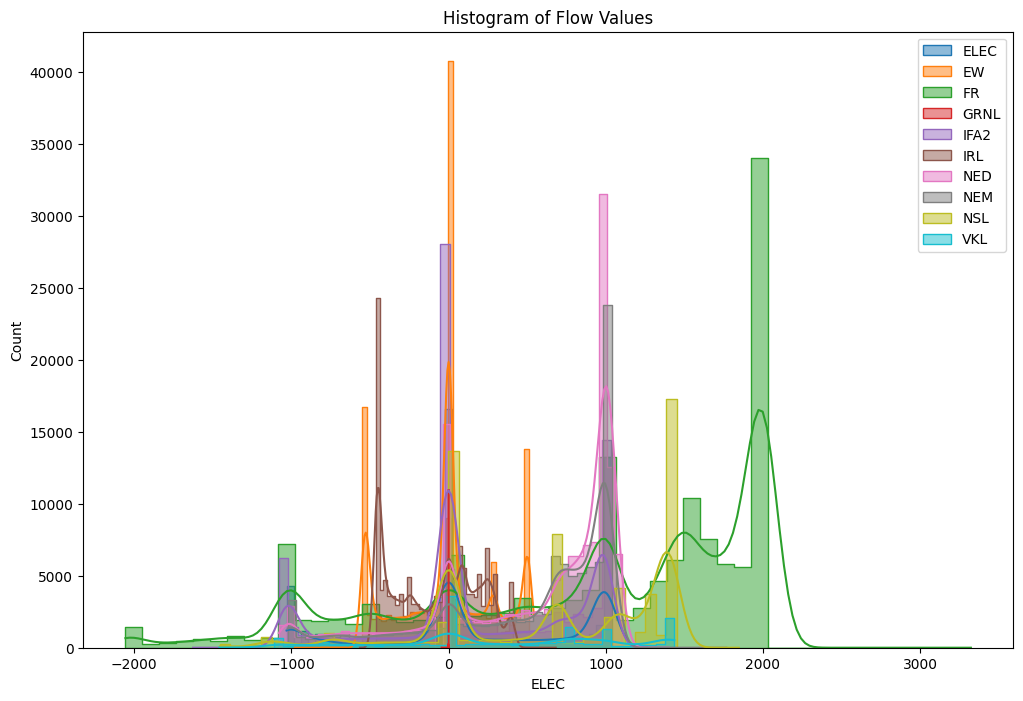

In [5]:
# Seaborn histogram of all flow values in a single plot
plt.figure(figsize=(12, 8))
for col in int_cols:
    sns.histplot(df[col], bins=50, kde=True, label=col, element="step")
plt.title("Histogram of Flow Values")
plt.legend()
plt.show()

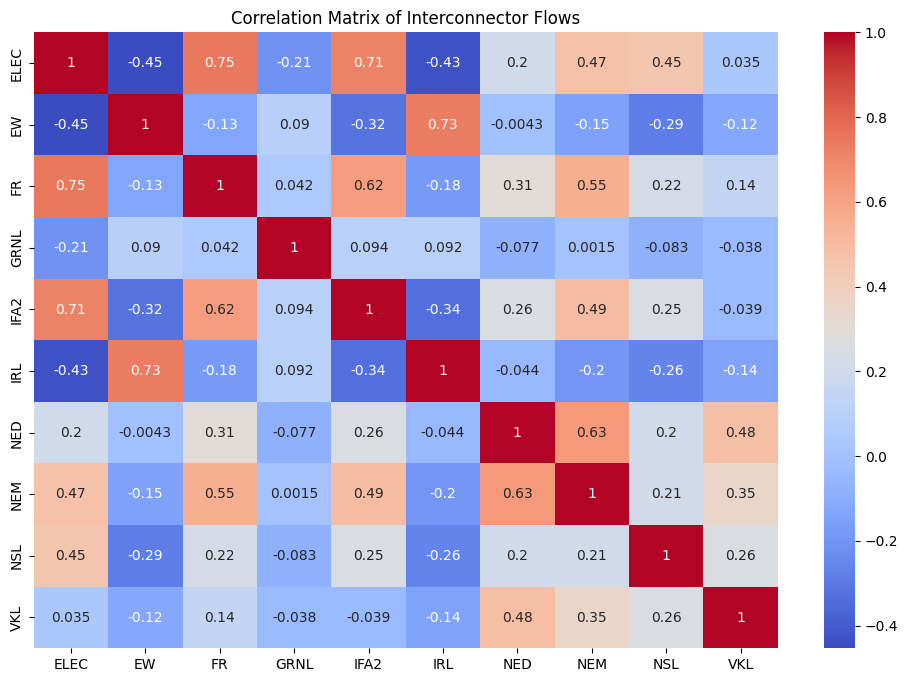

In [6]:
# Plot correlation matrix
corr = df[int_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Interconnector Flows")
plt.show()

In [7]:
# Find the minimum and maximum flow values for each interconnector
min_flows = df[int_cols].min()
max_flows = df[int_cols].max()
min_max_df = pd.DataFrame({"min": min_flows, "max": max_flows})
min_max_df

,min,max
ELEC,-1031.333333,1260.666667
EW,-977.833333,542.000000
FR,-2056.500000,3322.666667
GRNL,-44.500000,0.000000
IFA2,-1626.166667,1397.666667
IRL,-564.000000,681.333333
NED,-1080.166667,1401.500000
NEM,-1024.000000,1766.333333
NSL,-1455.000000,1846.000000
VKL,-1459.000000,1436.000000


In [8]:
def flow_type(flow, min_flow, max_flow):
    margin = 0.1 * max(abs(min_flow), abs(max_flow))
    if abs(flow) <= margin:
        return "idle"
    elif abs(flow - min_flow) <= margin:
        return "max_export"
    elif abs(flow - max_flow) <= margin:
        return "max_import"
    elif flow > margin:
        return "import"
    elif flow < -margin:
        return "export"
    else:
        return flow


# Apply the flow_type function to each interconnector flow
flow_types = df[int_cols].apply(
    lambda x: x.apply(
        lambda y: flow_type(
            y, min_max_df.loc[x.name, "min"], min_max_df.loc[x.name, "max"]
        )
    )
)
# replace NaN values with 'nonexistent'
flow_types = flow_types.fillna("nonexistent")

# Concatenate the flow_types DataFrame with the original DataFrame
df = pd.concat(
    [df[["Year", "Month", "Day", "SettlementPeriod"]], flow_types], axis=1
)
df

,Year,Month,Day,SettlementPeriod,ELEC,EW,FR,GRNL,IFA2,IRL,NED,NEM,NSL,VKL
0,2016,2,29,48,nonexistent,import,import,nonexistent,nonexistent,import,import,nonexistent,nonexistent,nonexistent
1,2016,3,1,1,nonexistent,import,import,nonexistent,nonexistent,import,import,nonexistent,nonexistent,nonexistent
2,2016,3,1,2,nonexistent,import,import,nonexistent,nonexistent,import,import,nonexistent,nonexistent,nonexistent
3,2016,3,1,3,nonexistent,import,import,nonexistent,nonexistent,import,import,nonexistent,nonexistent,nonexistent
4,2016,3,1,4,nonexistent,import,import,nonexistent,nonexistent,import,import,nonexistent,nonexistent,nonexistent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152474,2024,11,23,37,idle,idle,import,idle,import,export,import,import,import,import
152475,2024,11,23,38,idle,idle,import,idle,import,export,import,import,import,import
152476,2024,11,23,39,idle,idle,import,idle,import,export,import,import,import,import
152477,2024,11,23,40,idle,idle,import,idle,import,idle,import,import,import,import


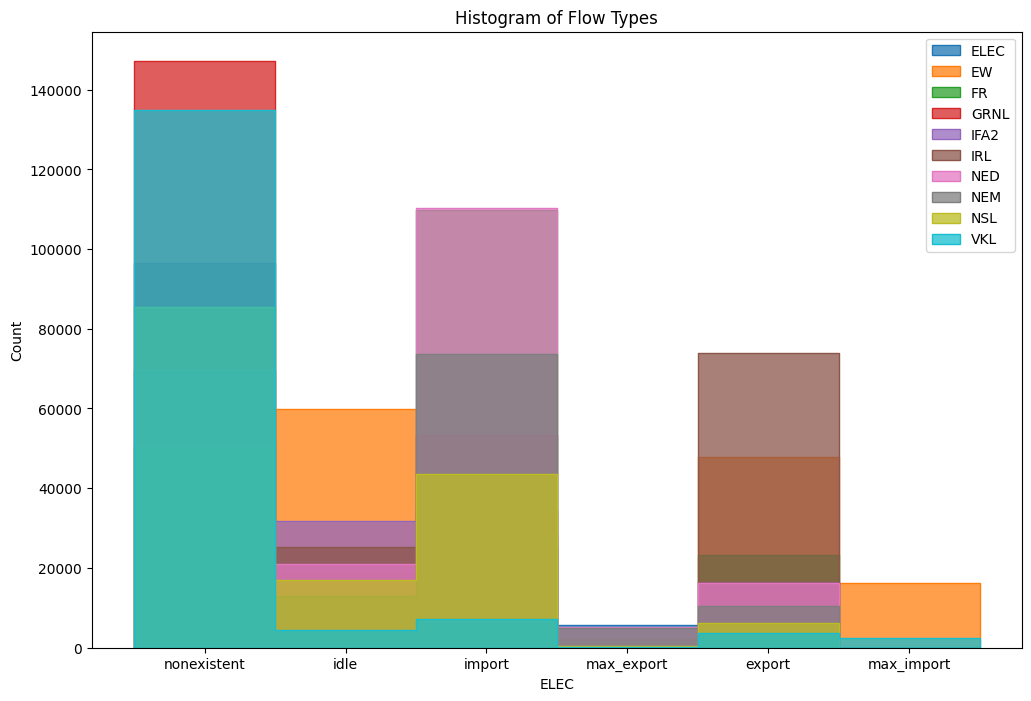

In [9]:
# Plot hisogram of flow types (treat each number as a category)
plt.figure(figsize=(12, 8))
for col in int_cols:
    sns.histplot(df[col], bins=5, kde=False, label=col, element="step")
plt.title("Histogram of Flow Types")
plt.legend()
plt.show()

In [10]:
# Encode Month and Day as cyclic features
df["DayOfTheYear"] = df["Month"] * 30 + df["Day"]
df["Day_sin"] = np.sin(2 * np.pi * df["DayOfTheYear"] / 365)
df["Day_cos"] = np.cos(2 * np.pi * df["DayOfTheYear"] / 365)
df = df.drop(columns=["Year", "Month", "Day", "DayOfTheYear"])

# Encode SettlementPeriod as cyclic feature
df["SettlementPeriod_sin"] = np.sin(2 * np.pi * df["SettlementPeriod"] / 48)
df["SettlementPeriod_cos"] = np.cos(2 * np.pi * df["SettlementPeriod"] / 48)
df = df.drop(columns=["SettlementPeriod"])

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [12]:
y_col = "FR"

class_labels = {
    "idle": 0,
    "import": 1,
    "max_import": 2,
    "export": 3,
    "max_export": 4,
    "nonexistent": 5,
}
df = df.replace(class_labels)

# Time shift to create sliding window features
shifts = 3
for i in range(1, shifts + 1):
    for col in int_cols:
        df[col + "_T-" + str(i)] = df[col].shift(i)
        df[col + "_T-" + str(i)] = df[col + "_T-" + str(i)].fillna(3)


# Drop rows with NaN values
df = df.dropna()
# Drop rows where y_col is 'nonexistent'
df = df[df[y_col] != 5]
# Delete columns of T=now
for col in set(int_cols) - set([y_col]):
    df = df.drop(columns=col)

print(list(df.columns))

X_cols = df.columns.drop(y_col)
X = df[X_cols]
y = df[y_col]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

['FR', 'Day_sin', 'Day_cos', 'SettlementPeriod_sin', 'SettlementPeriod_cos', 'ELEC_T-1', 'EW_T-1', 'FR_T-1', 'GRNL_T-1', 'IFA2_T-1', 'IRL_T-1', 'NED_T-1', 'NEM_T-1', 'NSL_T-1', 'VKL_T-1', 'ELEC_T-2', 'EW_T-2', 'FR_T-2', 'GRNL_T-2', 'IFA2_T-2', 'IRL_T-2', 'NED_T-2', 'NEM_T-2', 'NSL_T-2', 'VKL_T-2', 'ELEC_T-3', 'EW_T-3', 'FR_T-3', 'GRNL_T-3', 'IFA2_T-3', 'IRL_T-3', 'NED_T-3', 'NEM_T-3', 'NSL_T-3', 'VKL_T-3']
(121983, 34) (30496, 34) (121983,) (30496,)


/var/folders/_w/bcxbk4bn405bcm19pjyl4kcw0000gp/T/ipykernel_47973/3623945398.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(class_labels)


In [13]:
df

,FR,Day_sin,Day_cos,SettlementPeriod_sin,SettlementPeriod_cos,ELEC_T-1,EW_T-1,FR_T-1,GRNL_T-1,IFA2_T-1,...,ELEC_T-3,EW_T-3,FR_T-3,GRNL_T-3,IFA2_T-3,IRL_T-3,NED_T-3,NEM_T-3,NSL_T-3,VKL_T-3
0,1,0.999250,0.038722,-2.449294e-16,1.000000,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
1,1,0.999991,0.004304,1.305262e-01,0.991445,5.0,1.0,1.0,5.0,5.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2,1,0.999991,0.004304,2.588190e-01,0.965926,5.0,1.0,1.0,5.0,5.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
3,1,0.999991,0.004304,3.826834e-01,0.923880,5.0,1.0,1.0,5.0,5.0,...,5.0,1.0,1.0,5.0,5.0,1.0,1.0,5.0,5.0,5.0
4,1,0.999991,0.004304,5.000000e-01,0.866025,5.0,1.0,1.0,5.0,5.0,...,5.0,1.0,1.0,5.0,5.0,1.0,1.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152474,1,-0.205104,0.978740,-9.914449e-01,0.130526,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,3.0,1.0,1.0,1.0,1.0
152475,1,-0.205104,0.978740,-9.659258e-01,0.258819,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,3.0,1.0,1.0,1.0,1.0
152476,1,-0.205104,0.978740,-9.238795e-01,0.382683,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,3.0,1.0,1.0,1.0,1.0
152477,1,-0.205104,0.978740,-8.660254e-01,0.500000,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,3.0,1.0,1.0,1.0,1.0


In [14]:
df.describe()

,FR,Day_sin,Day_cos,SettlementPeriod_sin,SettlementPeriod_cos,ELEC_T-1,EW_T-1,FR_T-1,GRNL_T-1,IFA2_T-1,...,ELEC_T-3,EW_T-3,FR_T-3,GRNL_T-3,IFA2_T-3,IRL_T-3,NED_T-3,NEM_T-3,NSL_T-3,VKL_T-3
count,152479.000000,152479.000000,152479.000000,1.524790e+05,1.524790e+05,152479.000000,152479.000000,152479.000000,152479.000000,152479.000000,...,152479.000000,152479.000000,152479.000000,152479.000000,152479.000000,152479.000000,152479.000000,152479.000000,152479.000000,152479.000000
mean,1.235016,-0.028533,-0.032264,8.894808e-05,8.758658e-05,3.597066,1.339988,1.235029,4.827242,2.836509,...,3.597105,1.340027,1.235055,4.827281,2.836535,1.803612,1.174221,2.472275,3.217230,4.571633
std,0.891978,0.709620,0.703271,7.071010e-01,7.071172e-01,1.999139,1.279774,0.891989,0.913130,2.140492,...,1.999098,1.279779,0.892011,0.912987,2.140482,1.208083,0.911324,1.944384,2.084354,1.238505
min,0.000000,-0.999991,-0.999963,-1.000000e+00,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,-0.735417,-0.732494,-7.071068e-01,-7.071068e-01,1.000000,0.000000,1.000000,5.000000,1.000000,...,1.000000,0.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000
50%,1.000000,-0.060213,-0.064508,1.224647e-16,6.123234e-17,5.000000,1.000000,1.000000,5.000000,3.000000,...,5.000000,1.000000,1.000000,5.000000,3.000000,1.000000,1.000000,1.000000,5.000000,5.000000
75%,1.000000,0.693281,0.664855,7.071068e-01,7.071068e-01,5.000000,3.000000,1.000000,5.000000,5.000000,...,5.000000,3.000000,1.000000,5.000000,5.000000,3.000000,1.000000,5.000000,5.000000,5.000000
max,4.000000,0.999991,1.000000,1.000000e+00,1.000000e+00,5.000000,4.000000,4.000000,5.000000,5.000000,...,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,5.000000


In [15]:
print(y_train.value_counts())
print(y_test.value_counts())

FR
1    87915
3    18579
0    13731
4     1756
2        2
Name: count, dtype: int64
FR
1    21925
3     4699
0     3468
4      402
2        2
Name: count, dtype: int64


In [19]:
# Classification model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [21]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.941303777544596


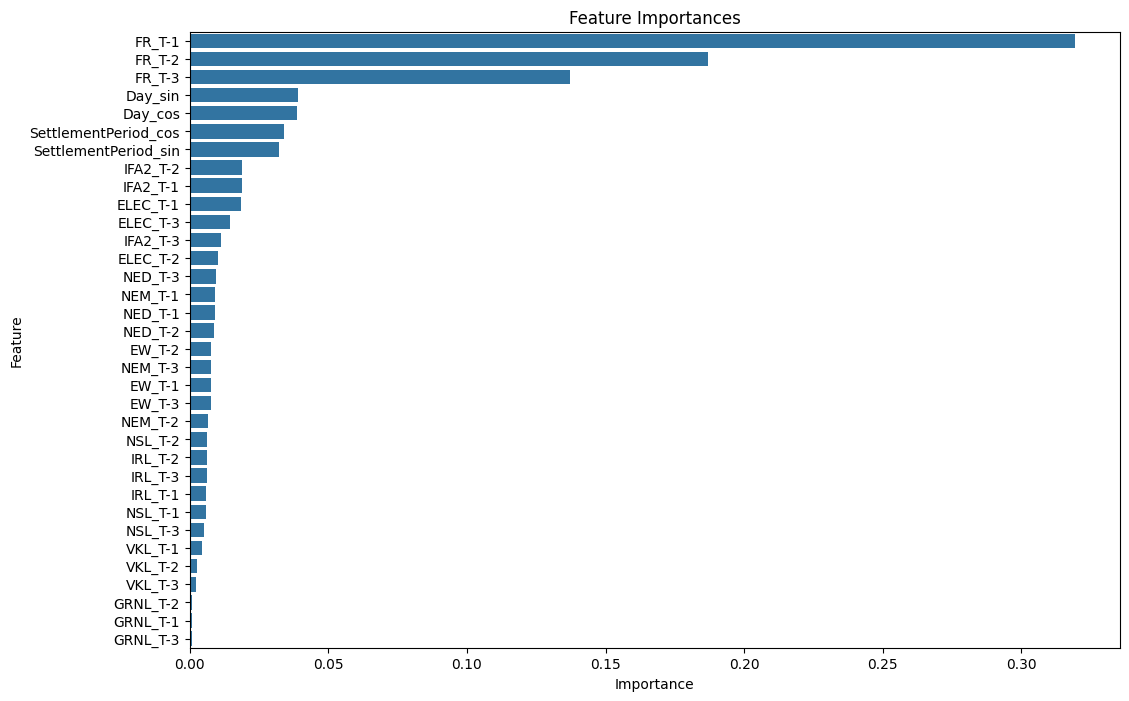

In [22]:
# Plot feature importances
importances = clf.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 8))
sns.barplot(y=X.columns[indices], x=importances[indices])
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param_grid = {
    "n_estimators": range(50, 200, 5),
    "max_depth": range(5, 20),
    "min_samples_split": range(2, 10),
    "min_samples_leaf": range(1, 5),
}

clf = RandomizedSearchCV(
    RandomForestClassifier(n_estimators=100, random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=2,
    n_iter=5,
)
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)
print(clf.best_estimator_)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/ll3524/anaconda3/envs/gb-flow/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   6.9s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   7.0s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   7.1s
[CV] END max_depth=12, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   9.1s
[CV] END max_depth=12, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   9.2s
[CV] END max_depth=12, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   9.3s
[CV] END max_depth=12, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   9.3s
[CV] END max_depth=12, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   9.6s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   6.4s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=150; total time=   

[[ 2706   454     0   303     5]
 [  337 21511     0    77     0]
 [    0     2     0     0     0]
 [  303    87     0  4260    49]
 [    1     0     0    81   320]]


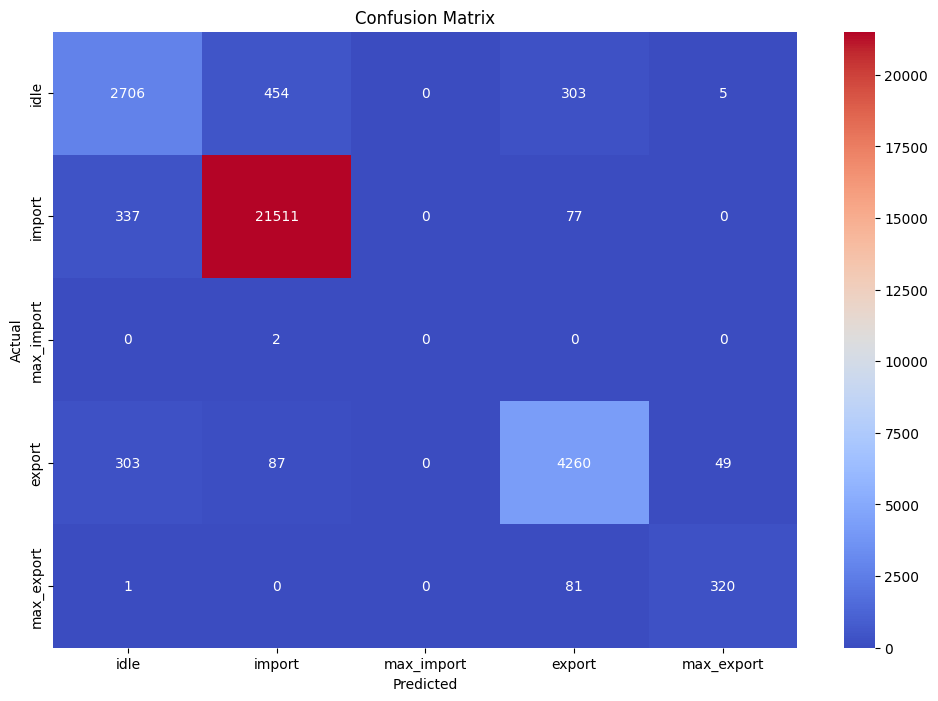

In [18]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
plt.figure(figsize=(12, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="coolwarm",
    xticklabels=list(class_labels.keys())[:-1],
    yticklabels=list(class_labels.keys())[:-1],
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()